# Fu_Xinyao_Project

Name: Xinyao Fu  
Github Username: xinyaofu  
USC ID: 3110633602

### Packages Import

In [1]:
import os
import re
import string
import shutil
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D, LSTM

### Data Exploration and Pre-processing

In [2]:
# Remove the punctuation and numbers
def clean_data(path):
    files = os.listdir(path)
    for file_name in files:
        file_path = os.path.join(path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        cleaned_text = re.sub(r'\d+', '', text)
        cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(cleaned_text)

neg_path = '../data/neg'
clean_data(neg_path)
pos_path = '../data/pos'
clean_data(pos_path)

In [3]:
# split data into train set and test set
def split_data(folder_path, output_path):
    train_path = os.path.join(output_path, 'train')
    test_path = os.path.join(output_path, 'test')

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    files = os.listdir(folder_path)
    
    for file_nm in files:
        number = int(file_nm[2:5])
        if 0 <= number <= 699:
            target_folder = train_path
        elif 700 <= number <= 999:
            target_folder = test_path
        else:
            continue

        source_file = os.path.join(folder_path, file_nm)
        destination_file = os.path.join(target_folder, file_nm)
        shutil.copy(source_file, destination_file)

output_pos = '../data/splitted/pos'
output_neg = '../data/splitted/neg'

split_data(neg_path, output_neg)
split_data(pos_path, output_pos)

In [4]:
# count the number of unique words in the whole dataset
base_dir = Path('../data/splitted')
unique_words = set()

for path in base_dir.glob('**/*.txt'):
    with open(path, 'r', encoding='utf-8') as file:
        words = file.read().split()
        unique_words.update(words)

count_uw = len(unique_words)
print(f'The number of unique words in the whole dataset is {count_uw}')

The number of unique words in the whole dataset is 46830


In [5]:
# Calculate the average review length and the standard deviation of review lengths
lengths = []
for path in base_dir.glob('**/*.txt'):
    with open(path, 'r', encoding='utf-8') as file:
        content = file.read()
        words = content.split()
        lengths.append(len(words))

avg_length = np.mean(lengths)
std_deviation = np.std(lengths)

print(f'Average review length is {avg_length}')
print(f'Standard deviation of review lengths is {std_deviation}')

Average review length is 644.3555
Standard deviation of review lengths is 284.97987142910637


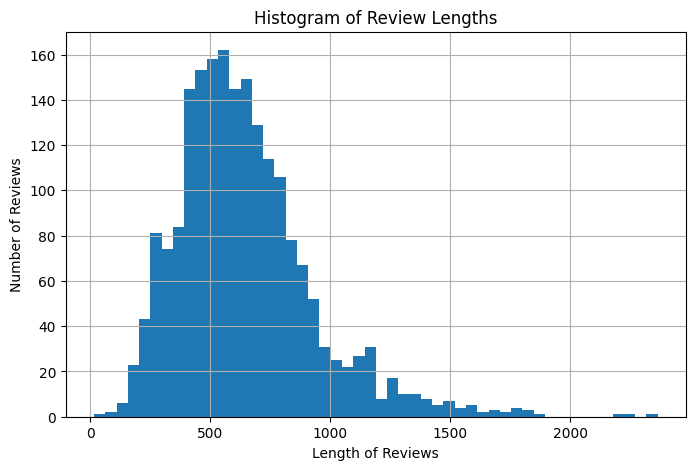

In [6]:
# Plot the histogram of review lengths
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=50)
plt.title('Histogram of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

In [7]:
# Select an length L that 70% of the reviews have a length below it
L = int(np.percentile(lengths, 70))
print(f"L is {int(L)}")

L is 737


In [8]:
# Tokenization, use binary encoding for the sentiments, and make all reviews to have the same length L
base_dir = Path('../data/splitted')
tokenizer = Tokenizer()

train_data = []
train_labels = []
test_data = []
test_labels = []

for sentiment in ['pos', 'neg']:
    sentiment_label = 1 if sentiment == 'pos' else -1
    for dataset_type in ['train', 'test']:
        dataset_path = base_dir / sentiment / dataset_type
        for file_path in dataset_path.glob('*.txt'):
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
            tokenizer.fit_on_texts([text])
            sequence = tokenizer.texts_to_sequences([text])
            result_sequence = pad_sequences(sequence, maxlen=L, padding='post', truncating='post')

            if dataset_type == 'train':
                train_data.append(result_sequence)
                train_labels.append(sentiment_label)
            else:
                test_data.append(result_sequence)
                test_labels.append(sentiment_label)

train_data = np.vstack(train_data)
train_labels = np.array(train_labels)
test_data = np.vstack(test_data)
test_labels = np.array(test_labels)

np.save('../data/train_data.npy', train_data)
np.save('../data/train_labels.npy', train_labels)
np.save('../data/test_data.npy', test_data)
np.save('../data/test_labels.npy', test_labels)

### Word Embeddings

In [9]:
top_words = 5000
model = Sequential()
model.add(Embedding(top_words, 32, input_length=L))
model.add(Flatten())

C:\Users\lenovo\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Multi-Layer Perceptron

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [10]:
model.add(Dense(50, activation='relu')) # first hidden layer
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu')) # second hidden layer
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu')) # third hidden layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # output layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
train_data = np.load('../data/train_data.npy')
train_labels = np.load('../data/train_labels.npy')
test_data = np.load('../data/test_data.npy')
test_labels = np.load('../data/test_labels.npy')

train_data = np.clip(train_data, 0, top_words - 1)
test_data = np.clip(test_data, 0, top_words - 1)
train_labels = (train_labels + 1) / 2
test_labels = (test_labels + 1) / 2

history = model.fit(train_data, train_labels, epochs=2, batch_size=10, validation_data=(test_data, test_labels))

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]
print(f'Train Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4997 - loss: 0.7003 - val_accuracy: 0.5000 - val_loss: 0.7035
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6358 - loss: 0.6520 - val_accuracy: 0.5150 - val_loss: 0.7142
Train Accuracy: 0.6549999713897705
Test Accuracy: 0.5149999856948853


### One-Dimensional Convolutional Neural Network

In [12]:
top_words = 5000
model = Sequential()
model.add(Embedding(top_words, 32, input_length=L))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())

In [13]:
model.add(Dense(50, activation='relu'))  # first hidden layer
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))  # second hidden layer
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))  # third hidden layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # output layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(train_data, train_labels, epochs=2, batch_size=10, validation_data=(test_data, test_labels))

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]
print(f'Train Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4789 - loss: 0.7025 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5219 - loss: 0.6900 - val_accuracy: 0.5500 - val_loss: 0.6893
Train Accuracy: 0.5285714268684387
Test Accuracy: 0.550000011920929


### Long Short-Term Memory Recurrent Neural Network

In [15]:
top_words = 5000
model = Sequential()
model.add(Embedding(top_words, 32, input_length=L))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))  # LSTM Layer
model.add(Dense(256, activation='relu')) # dense layer
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # output layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(train_data, train_labels, epochs=20, batch_size=10, validation_data=(test_data, test_labels))

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.5450 - loss: 0.6907 - val_accuracy: 0.5600 - val_loss: 0.6872
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - accuracy: 0.5361 - loss: 0.6872 - val_accuracy: 0.5583 - val_loss: 0.6835
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - accuracy: 0.5299 - loss: 0.6618 - val_accuracy: 0.5500 - val_loss: 0.6964
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - accuracy: 0.6593 - loss: 0.5959 - val_accuracy: 0.5517 - val_loss: 0.7923
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - accuracy: 0.6496 - loss: 0.5324 - val_accuracy: 0.5233 - val_loss: 0.8324
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.6551 - loss: 0.4991 - val_accuracy: 0.5317 - val_loss: 1.0462
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.6671 - loss: 0.4987 - val_accuracy: 0.5300 - val_loss: 1.0428
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - accuracy: 0.6653 - loss: 0

In [17]:
train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]
print(f'Train Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')

Train Accuracy: 0.6785714030265808
Test Accuracy: 0.5149999856948853


The train accuracy improved a lot using LSTM, but the test accuray remains at the same level

In [18]:
# Using 50 epoches
history = model.fit(train_data, train_labels, epochs=50, batch_size=10, validation_data=(test_data, test_labels))

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.6753 - loss: 0.4912 - val_accuracy: 0.5067 - val_loss: 1.2129
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.6788 - loss: 0.5009 - val_accuracy: 0.5233 - val_loss: 1.1896
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.6989 - loss: 0.4823 - val_accuracy: 0.5200 - val_loss: 1.3001
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - accuracy: 0.6915 - loss: 0.4688 - val_accuracy: 0.5167 - val_loss: 1.4027
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.7132 - loss: 0.4654 - val_accuracy: 0.5100 - val_loss: 1.4619
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 287ms/step - accuracy: 0.6723 - loss: 0.4838 - val_accuracy: 0.5150 - val_loss: 1.5826
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.6886 - loss: 0.4838 - val_accuracy: 0.5267 - val_loss: 1.1829
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - accuracy: 0.6831 - loss: 0

In [19]:
train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]
print(f'Train Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')

Train Accuracy: 0.9850000143051147
Test Accuracy: 0.5316666960716248


The train accuracy significantly improved when using more epochs, but the test accuray still remains at the same level.